ПРОГНОЗИРОВАНИЕ СРЕДНЕМЕСЯЧНОЙ ЗАРАБОТНОЙ ПЛАТЫ

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# 1 Проведём визуальный анализ ряда

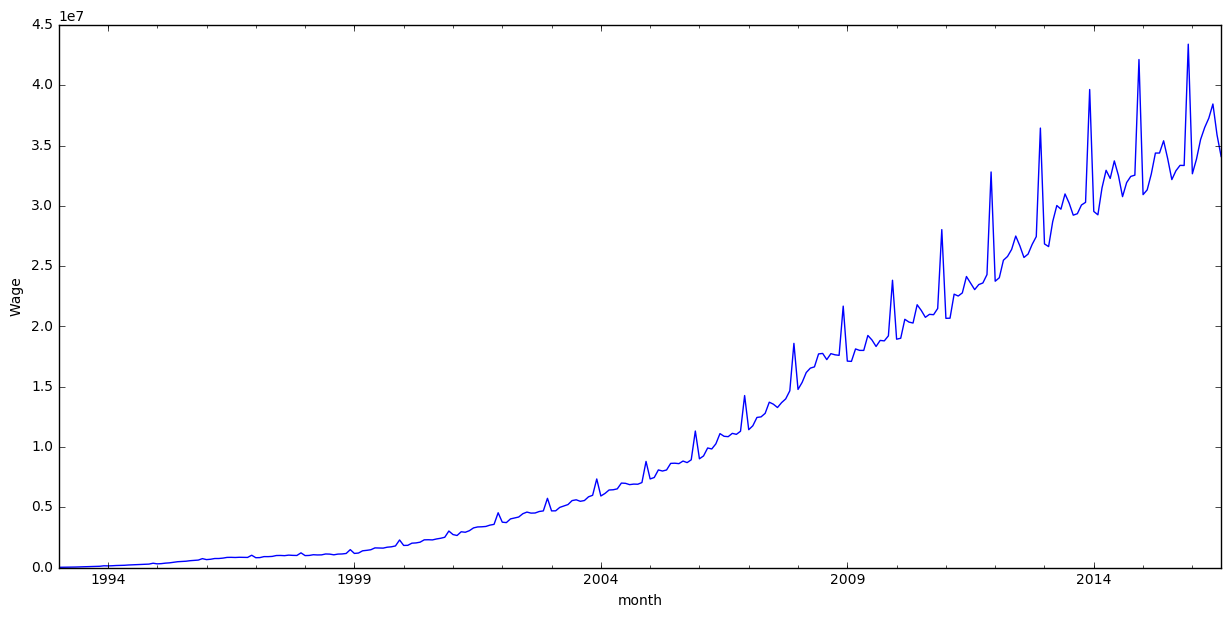

In [2]:
wage = pd.read_csv('monthly_wages.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
wage.columns = ['amount']
wage.amount = wage.amount * 1000
plt.figure(figsize(15,7))
wage.amount.plot()
plt.ylabel('Wage')
pylab.show()

In [ ]:
# Очевидно, что необходимо проведение стабилизации дисперсии. Проведём его, используя преобразование Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


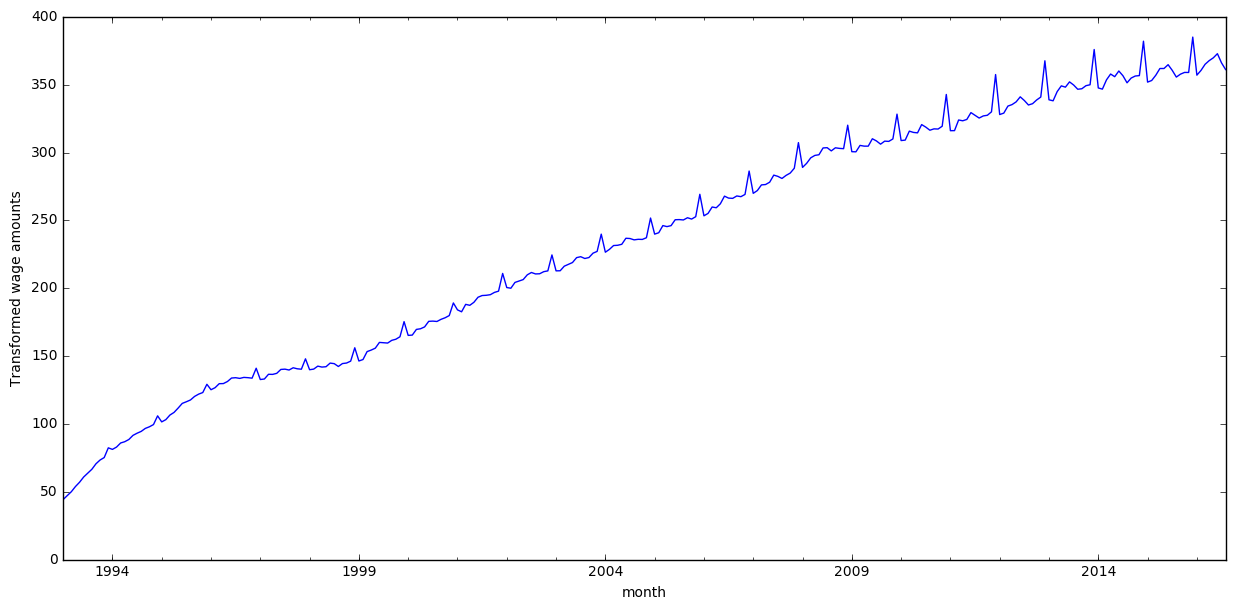

In [3]:
wage['amount_box'], lmbda = stats.boxcox(wage.amount)
plt.figure(figsize(15,7))
wage.amount_box.plot()
plt.ylabel(u'Transformed wage amounts')
print "Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.amount_box)[1]

In [ ]:
# Ряд нестационарный, применим дифференцирование

Критерий Дики-Фуллера: p=0.014697


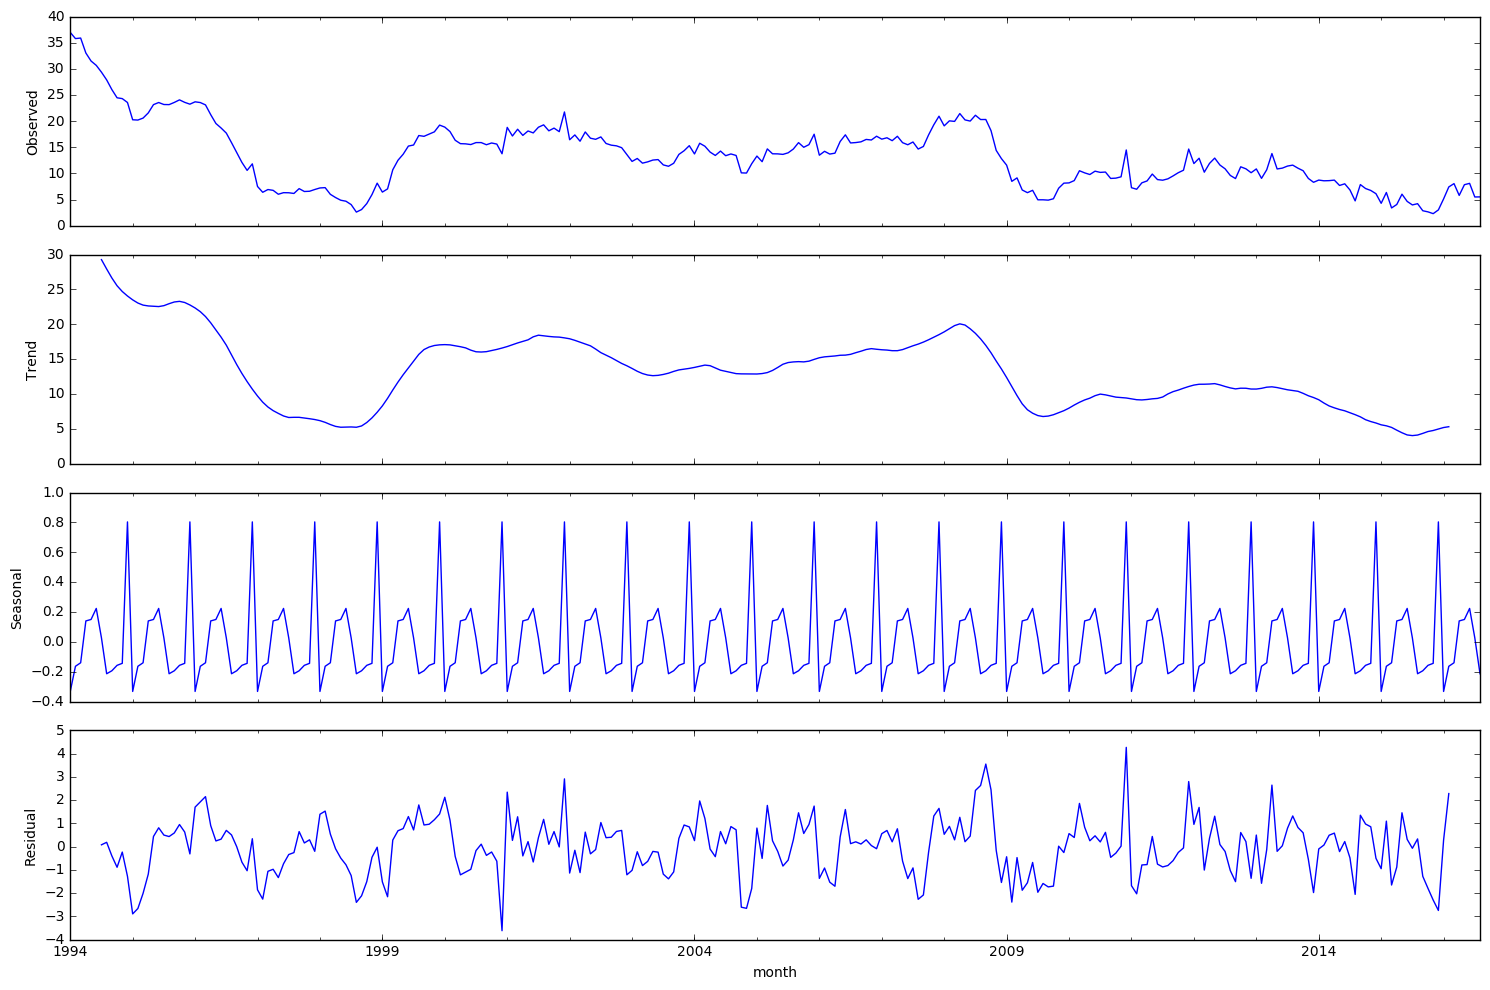

In [4]:
wage['amount_box_diff'] = wage.amount_box - wage.amount_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.amount_box_diff[12:]).plot()
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.amount_box_diff[12:])[1]

In [ ]:
#Выбор порядка дифференцирования. В нашей задаче оказалось достаточно одного сезонного дифференцирования, после которого
#p = 0.015 < 0.05
#Соответственно, уже на этом этапе можно сказать, что D = 1, d = 0. 


Подбор модели

In [ ]:
# Выбор начальных приближений для p,q,P,Q

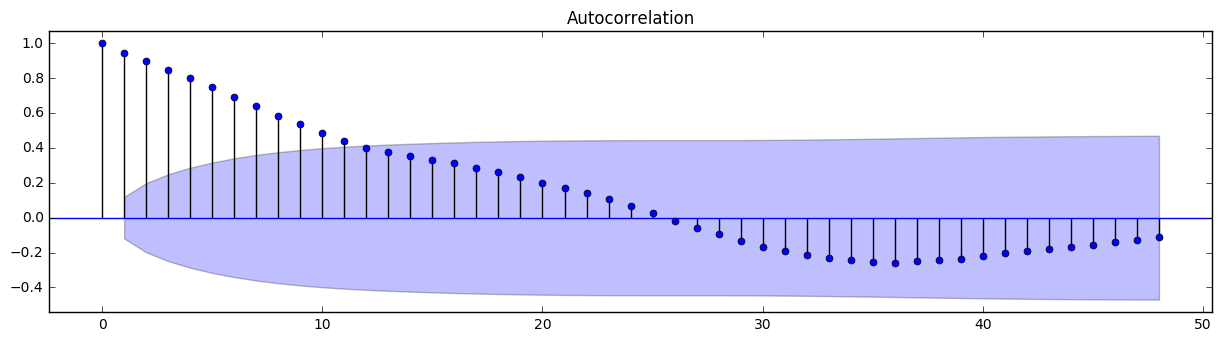

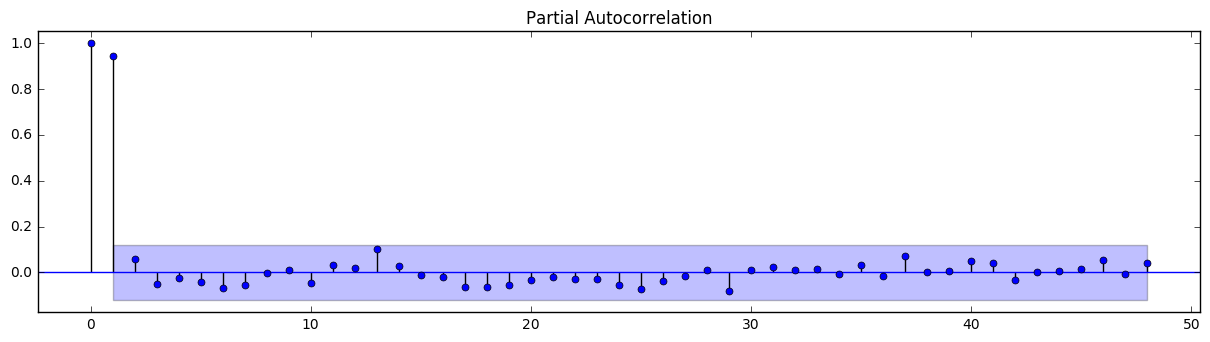

In [5]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.amount_box_diff[12:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.amount_box_diff[12:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [ ]:
#По графику определяем параметры модели: Q =0 ,q =11 ,P =0 ,p = 1

In [28]:
ps = range(0, 2)
d=0
qs = range(0, 12)
Ps = range(0, 1)
D=1
Qs = range(0, 1)

In [29]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [30]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.amount_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print ('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (0, 3, 0, 0))
('wrong parameters:', (0, 4, 0, 0))
('wrong parameters:', (0, 5, 0, 0))
('wrong parameters:', (0, 6, 0, 0))
('wrong parameters:', (0, 7, 0, 0))
('wrong parameters:', (0, 8, 0, 0))
('wrong parameters:', (0, 9, 0, 0))
('wrong parameters:', (0, 10, 0, 0))
('wrong parameters:', (0, 11, 0, 0))
Wall time: 17 s


In [ ]:
# выбираем лучшую модель

In [31]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print result_table.sort_values(by = 'aic', ascending=True).head()

       parameters         aic
11   (1, 9, 0, 0)  981.141924
12  (1, 10, 0, 0)  982.364522
13  (1, 11, 0, 0)  983.894651
10   (1, 8, 0, 0)  984.679053
9    (1, 7, 0, 0)  986.341106


In [32]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                         amount_box   No. Observations:                  284
Model:             SARIMAX(1, 0, 9)x(0, 1, 0, 12)   Log Likelihood                -479.571
Date:                            Thu, 06 Oct 2016   AIC                            981.142
Time:                                    07:14:06   BIC                           1021.281
Sample:                                01-01-1993   HQIC                           997.234
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9894      0.007    140.132      0.000       0.976       1.003
ma.L1         -0.1914      0.049   

In [ ]:
# Теперь необходимо проверить остатки

Критерий Стьюдента: p=0.394123
Критерий Дики-Фуллера: p=0.000000


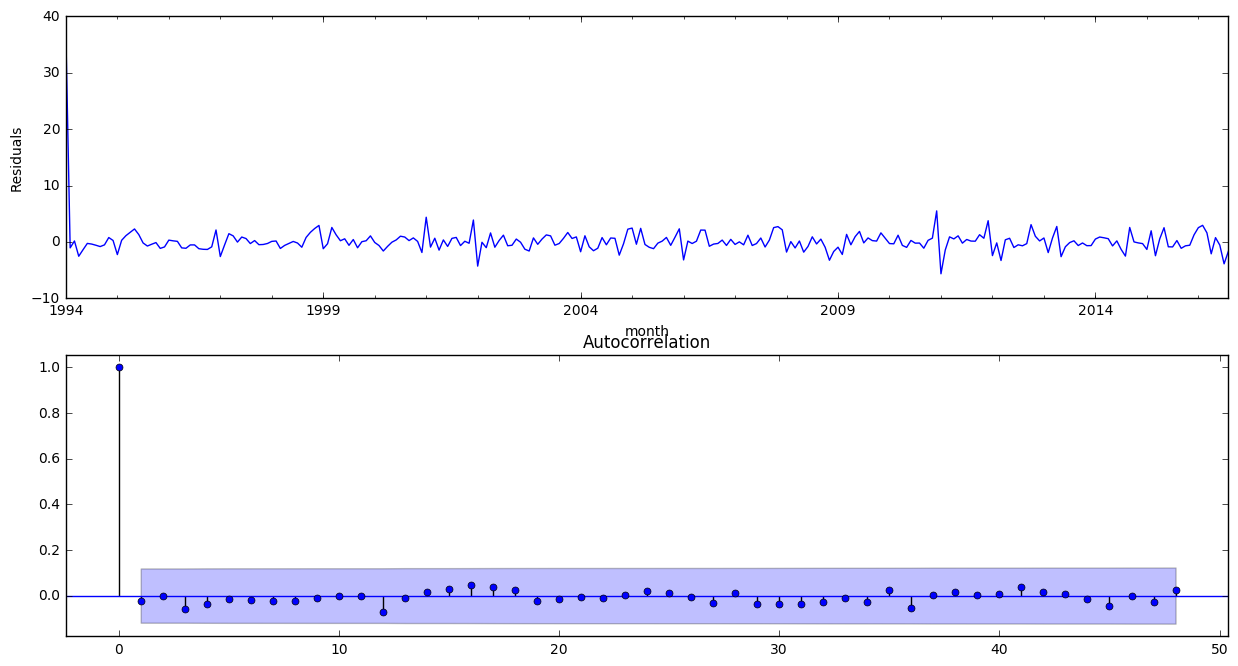

In [33]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[12:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags=48, ax=ax)

print "Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[12:], 0)[1]
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1]

In [ ]:
# И визуально, и по критериям остатки несмещены и неавтокоррелированы. Можно продолжать дальше. 

In [ ]:
# Теперь проверим, насколько хорошо модель описывает данные

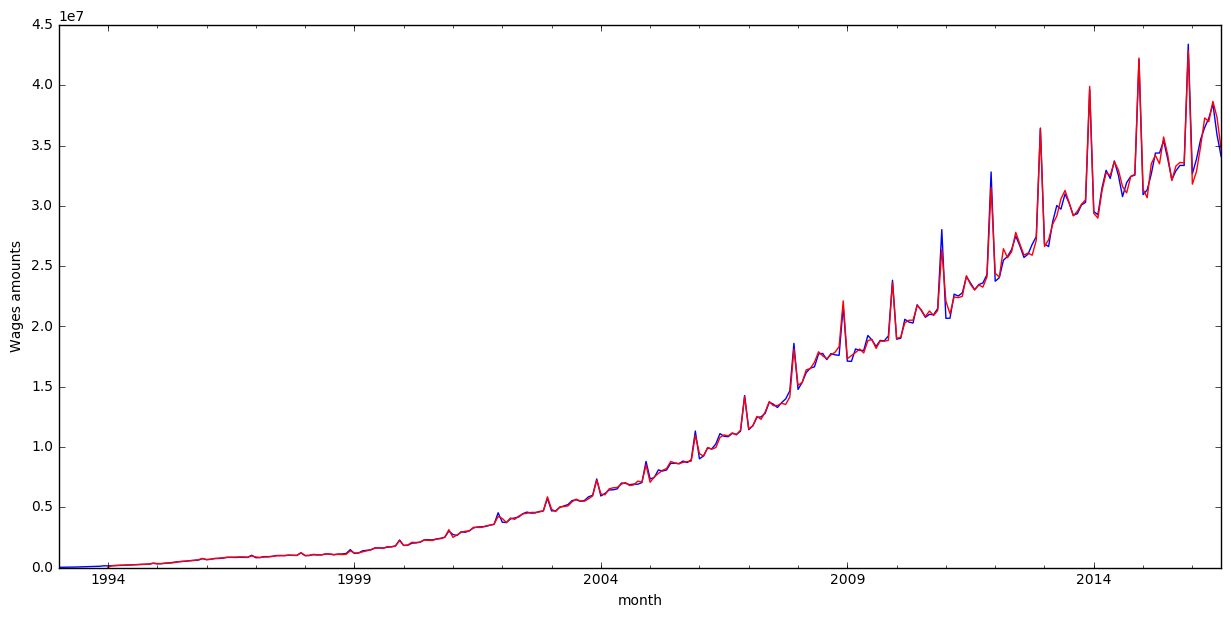

In [34]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage.amount.plot()
wage.model[12:].plot(color='r')
plt.ylabel('Wages amounts')
pylab.show()

In [ ]:
# Далее идёт сам прогноз

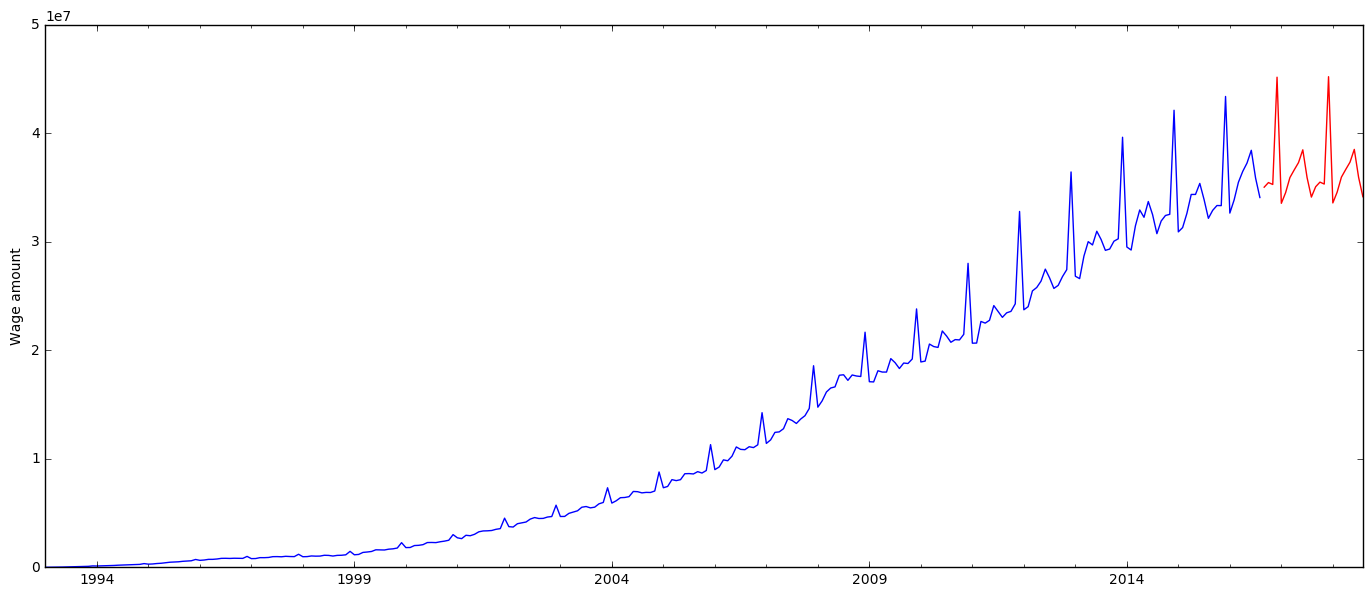

In [35]:
wage2 = wage[['amount']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(17,7))
wage2.amount.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Wage amount')
pylab.show()